<a href="https://colab.research.google.com/github/karthikvijayakumar/EVA/blob/vijkar_development/Project%209/Assignment_9_EVA_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References used for this assignment:

1. https://github.com/ramprs/grad-cam/issues/8
2. https://eli5.readthedocs.io/en/latest/tutorials/keras-image-classifiers.html
3. https://medium.com/@mohamedchetoui/grad-cam-gradient-weighted-class-activation-mapping-ffd72742243a
4. https://github.com/eclique/keras-gradcam

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.preprocessing import image
import cv2
import sys
from google.colab.patches import cv2_imshow
import random

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


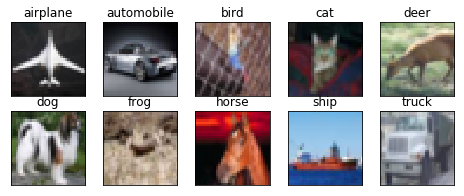

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Improved model from assignment 6A with modifications

The model submitted for 6A has been changed here since my 6A model did not have the following features:

1. The layer next to the softmax did not have a large enough image size where the grad cam could be used
2. The model did not use padding when building convolution layers

In [0]:
# Define the model

dropout_rate = 0.15

model = Sequential()

# Convolution block
model.add(Convolution2D(64, (3, 3), input_shape=(32, 32, 3), border_mode = 'same')) # RF: 3x3
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Convolution2D(128, (3, 3), border_mode = 'same')) # RF: 5x5
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Convolution2D(256, (3, 3), border_mode = 'same')) # RF: 7x7
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Transition block
model.add(MaxPooling2D(pool_size=(2, 2))) # RF: 14x14
model.add(Dropout(dropout_rate))
model.add(Convolution2D(64, (1, 1))) # RF: 14x14
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Convolution block
model.add(Convolution2D(128, (3, 3), border_mode = 'same')) # RF: 16x16
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Convolution2D(256, (3, 3), border_mode = 'same')) # RF: 18x18
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Transition block
model.add(MaxPooling2D(pool_size=(2, 2))) # RF: 36x36
model.add(Dropout(dropout_rate))
model.add(Convolution2D(64, (1, 1))) # RF: 36x36
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Convolution block
model.add(Convolution2D(128, (3, 3), border_mode = 'same')) # RF: 38x38
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Convolution2D(256, (3, 3), border_mode = 'same')) # RF: 40x40
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Convolution block
model.add(Convolution2D(10, (8, 8))) # RF: ???
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Flattenign and output layer
model.add(Flatten())
model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  import sys



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), padding="same")`


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 128)      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=25)`


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
390/390 [==============================] - 59s 152ms/step - loss: 1.5525 - acc: 0.4633 - val_loss: 1.2121 - val_acc: 0.5947

Epoch 00001: val_acc improved from -inf to 0.59470, saving model to /content/gdrive/My Drive/Colab Notebooks/eva2_9a_model_weights.hdf5
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.0009708738.
390/390 [==============================] - 52s 133ms/step - loss: 1.1379 - acc: 0.6159 - val_loss: 0.8850 - val_acc: 0.7142

Epoch 00002: val_acc improved from 0.59470 to 0.71420, saving model to /content/gdrive/My Drive/Colab Notebooks/eva2_9a_model_weights.hdf5
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.0009433962.
390/390 [==============================] - 52s 133ms/step - loss: 0.9614 - acc: 0.6761 - val_loss: 0.7789 - val_acc: 0.7439

Epoch

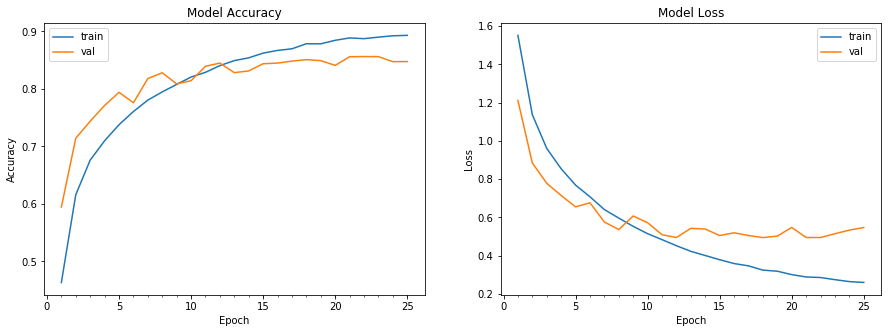

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def scheduler(epoch, lr):
  return round(0.001 * 1/(1 + 0.03 * epoch), 10)


datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)

model_weights_filepath="/content/gdrive/My Drive/Colab Notebooks/eva2_9a_model_weights.hdf5"
checkpoint = ModelCheckpoint(model_weights_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, LearningRateScheduler(scheduler, verbose=1)]

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 25, 
                                 validation_data = (test_features, test_labels), callbacks = callbacks_list,
                                 verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)

In [0]:
#Load the best model weights according to validation accuracy
model_weights_filepath="/content/gdrive/My Drive/Colab Notebooks/eva2_9a_model_weights.hdf5"
model.load_weights(model_weights_filepath)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 85.63


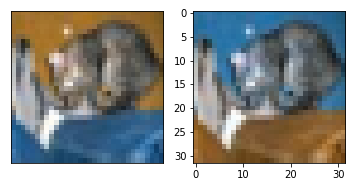

In [0]:
# Basic syntax to display an image 
fig, ax = plt.subplots(1,2)

ax[0].imshow( test_features[0] )
ax[1].imshow( cv2.cvtColor(test_features[0], cv2.COLOR_BGR2RGB) )
ax[0].set_xticks([],[])
ax[0].set_yticks([],[]);

# Image on the left is without correcting the order of the colors to support non-opencv libraries
# Image on the right has the color order corrected for non-opencv libraries

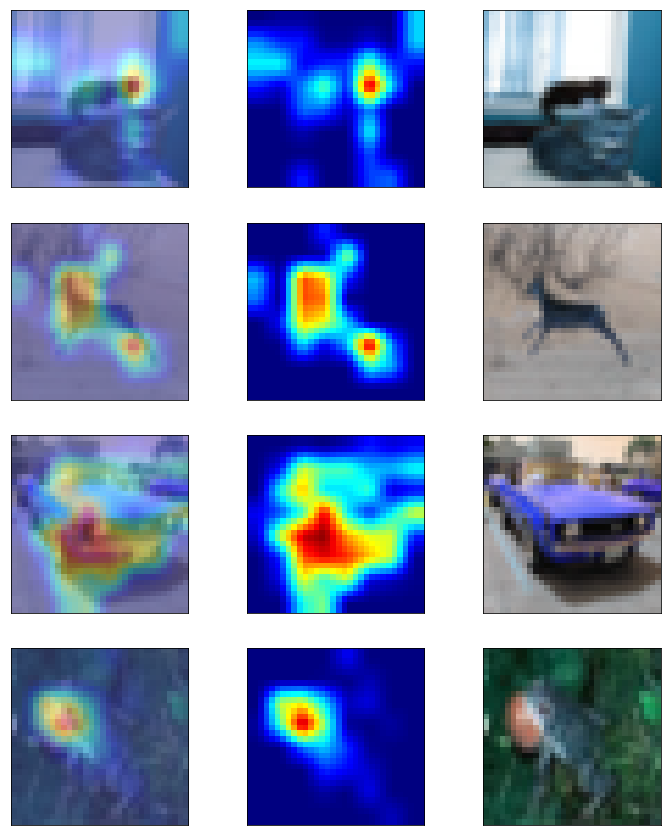

In [0]:
target_image_idx=[]
fig, ax = plt.subplots(4,3, figsize = (12,15))

for i in range(4):
    current_target_idx = random.randint(0,test_features.shape[0]-1)
    target_image_idx.append( current_target_idx )

    test_image = test_features[current_target_idx].reshape((1,32,32,3))

    preds = model.predict(test_image)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("batch_normalization_9")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([test_image])
    for j in range(10):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    #     heatmap = heatmap - np.amin( heatmap ) #Shifting the minimum to zero    

    if(heatmap.max() < 0 ):
        print('Danger Will Robinson!! All gradients are negative!')

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) # Scaling the maximum to one    

    test_image = test_image[0] #.reshape( (32,32,3) )
    heatmap = cv2.resize(heatmap, (test_image.shape[1], test_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    #Converting color schemes to RGB
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    ax[i][0].imshow(heatmap, alpha = 0.7)
    ax[i][0].imshow(test_image, alpha = 0.5)
    ax[i][0].set_xticks([],[])
    ax[i][0].set_yticks([],[]);

    ax[i][1].imshow(heatmap)
    ax[i][1].set_xticks([],[])
    ax[i][1].set_yticks([],[]);

    ax[i][2].imshow(test_image)
    ax[i][2].set_xticks([],[])
    ax[i][2].set_yticks([],[]);

In [0]:
print(target_image_idx)

[1065, 1590, 8623, 9738]


Comments for each example:

1. The model seems to be primarily looking at the end of the tail of the animal
2. The model is looking at the full body of the animal but nothing from its surroundings
3. The model is looking primarily at the headlight and front wheel of the car
4. The model is only looking at the head of the animal

Except for the second image, in all cases the model does not seem to look at the full object or the surroundings to idenitfy the object

# Section 2

Implementing cutout

Using the implementation from https://github.com/yu4u/cutout-random-erasing

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [0]:
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias_initializer'):
            layer.bias.initializer.run(session=session)
            

reset_weights(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., callbacks=[<keras.ca..., verbose=1, steps_per_epoch=390, epochs=25)`


Epoch 1/25

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
390/390 [==============================] - 56s 145ms/step - loss: 1.7471 - acc: 0.4025 - val_loss: 1.5796 - val_acc: 0.4882

Epoch 00001: val_acc improved from -inf to 0.48820, saving model to /content/gdrive/My Drive/Colab Notebooks/eva2_9b_model_weights.hdf5
Epoch 2/25

Epoch 00002: LearningRateScheduler setting learning rate to 0.0029126214.
390/390 [==============================] - 53s 136ms/step - loss: 1.1916 - acc: 0.5772 - val_loss: 1.0268 - val_acc: 0.6416

Epoch 00002: val_acc improved from 0.48820 to 0.64160, saving model to /content/gdrive/My Drive/Colab Notebooks/eva2_9b_model_weights.hdf5
Epoch 3/25

Epoch 00003: LearningRateScheduler setting learning rate to 0.0028301887.
390/390 [==============================] - 53s 136ms/step - loss: 1.0086 - acc: 0.6394 - val_loss: 0.9625 - val_acc: 0.6718

Epoch 00003: val_acc improved from 0.64160 to 0.67180, saving model to /content/gdrive/My Drive/Col

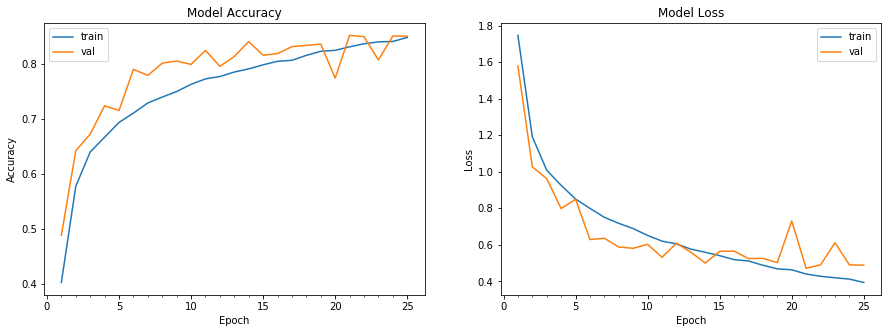

In [0]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.03 * epoch), 10)

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1))

model_with_cutout_weights_filepath="/content/gdrive/My Drive/Colab Notebooks/eva2_9b_model_weights.hdf5"
checkpoint = ModelCheckpoint(model_with_cutout_weights_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, LearningRateScheduler(scheduler, verbose=1)]

# Re-Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 25, 
                                 validation_data = (test_features, test_labels), callbacks = callbacks_list,
                                 verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)

In [0]:
#Load the best model weights according to validation accuracy
model_with_cutout_weights_filepath="/content/gdrive/My Drive/Colab Notebooks/eva2_9b_model_weights.hdf5"
model.load_weights(model_with_cutout_weights_filepath)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 85.11


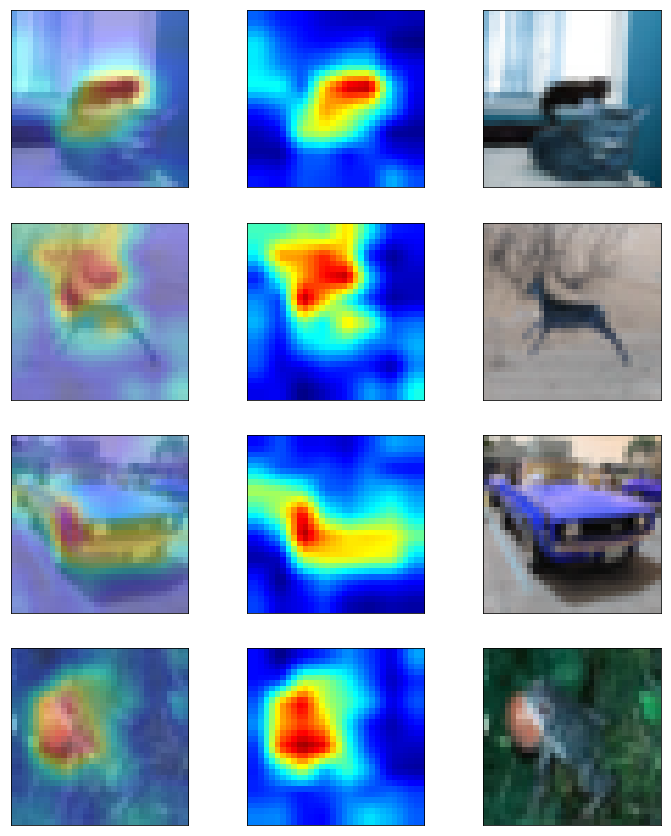

In [0]:
fig, ax = plt.subplots(4,3, figsize = (12,15))

for i in range(4):    
    current_target_idx = target_image_idx[i]

    test_image = test_features[current_target_idx].reshape((1,32,32,3))

    preds = model.predict(test_image)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("batch_normalization_9")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([test_image])
    for j in range(10):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = heatmap - np.amin( heatmap )
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    test_image = test_image.reshape( (32,32,3) )
    heatmap = cv2.resize(heatmap, (test_image.shape[1], test_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    #Converting color schemes to RGB
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
    ax[i][0].imshow(heatmap, alpha = 0.7)
    ax[i][0].imshow(test_image, alpha = 0.5)
    ax[i][0].set_xticks([],[])
    ax[i][0].set_yticks([],[]);

    ax[i][1].imshow(heatmap)
    ax[i][1].set_xticks([],[])
    ax[i][1].set_yticks([],[]);

    ax[i][2].imshow(test_image)
    ax[i][2].set_xticks([],[])
    ax[i][2].set_yticks([],[]);

Comments on each example:

1. The model is now looking at the full tail of the animal and a little bit of its body. This is an improvement from just looking at its tail.
2. The surroundings of the animal are now taken into purview by the model. Unfortunately the model seems to only focus on the head of the animal now though.
3. The side of the car has gained some focus now. The front headlamp area continues to dominate though.
4. The head of the animal still dominates the focus. However the area of focus now is larger than before.

Overall comments:

In general the model seems to look at slightly larger areas with cutout when compared to without cutout. There is a drop in validation accuracy though. However this drop in validation accuracy could potentially remove bias or make the model robust to obstructions or different conditions etc.

#Side by side comparison with and without cutout

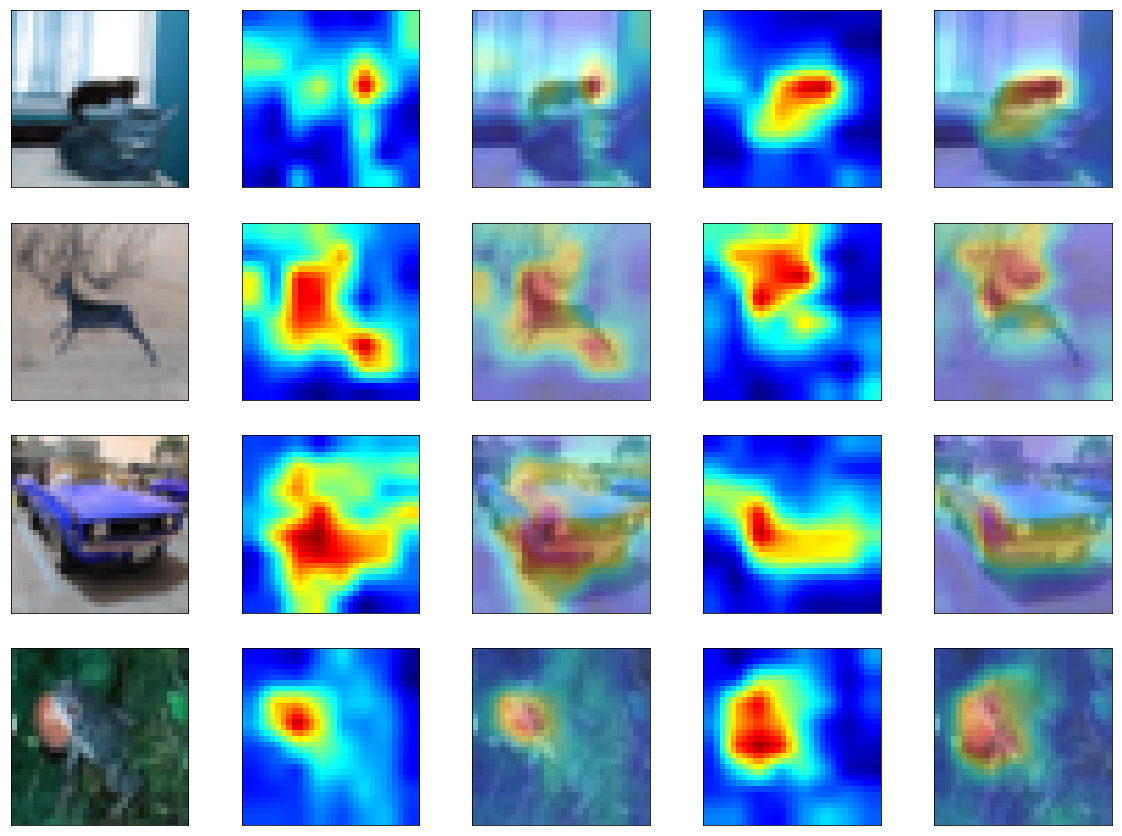

In [0]:
fig, ax = plt.subplots(4,5, figsize = (20,15))


#Show the base image
for i in range(4):
    current_target_idx = target_image_idx[i]
    test_image = test_features[current_target_idx].reshape((1,32,32,3))
    test_image = test_image.reshape( (32,32,3) )
    
    #Converting color schemes to RGB
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
    ax[i][0].imshow(test_image)
    ax[i][0].set_xticks([],[])
    ax[i][0].set_yticks([],[]);


#Loading model without cutout
model_weights_filepath="/content/gdrive/My Drive/Colab Notebooks/eva2_9a_model_weights.hdf5"
model.load_weights(model_weights_filepath)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#Heatmap and overlaid heatmap for model without cutout
for i in range(4):    
    current_target_idx = target_image_idx[i]
    test_image = test_features[current_target_idx].reshape((1,32,32,3))

    preds = model.predict(test_image)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("batch_normalization_9")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([test_image])
    for j in range(10):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = heatmap - np.amin( heatmap )
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    test_image = test_image.reshape( (32,32,3) )
    heatmap = cv2.resize(heatmap, (test_image.shape[1], test_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    #Converting color schemes to RGB
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
   
    #Heatmap only
    ax[i][1].imshow(heatmap)
    ax[i][1].set_xticks([],[])
    ax[i][1].set_yticks([],[]);

    #Overlay of heatmap on image
    ax[i][2].imshow(heatmap, alpha = 0.7)
    ax[i][2].imshow(test_image, alpha = 0.5)
    ax[i][2].set_xticks([],[])
    ax[i][2].set_yticks([],[]);
    
#Loading model without cutout
model_weights_filepath="/content/gdrive/My Drive/Colab Notebooks/eva2_9b_model_weights.hdf5"
model.load_weights(model_weights_filepath)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#Heatmap and overlaid heatmap for model without cutout
for i in range(4):    
    current_target_idx = target_image_idx[i]
    test_image = test_features[current_target_idx].reshape((1,32,32,3))

    preds = model.predict(test_image)
    class_idx = np.argmax(preds[0])
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("batch_normalization_9")

    grads = K.gradients(class_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([test_image])
    for j in range(10):
        conv_layer_output_value[:, :, j] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = heatmap - np.amin( heatmap )
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    test_image = test_image.reshape( (32,32,3) )
    heatmap = cv2.resize(heatmap, (test_image.shape[1], test_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    #Converting color schemes to RGB
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
   
    #Heatmap only
    ax[i][3].imshow(heatmap)
    ax[i][3].set_xticks([],[])
    ax[i][3].set_yticks([],[]);

    #Overlay of heatmap on image
    ax[i][4].imshow(heatmap, alpha = 0.7)
    ax[i][4].imshow(test_image, alpha = 0.5)
    ax[i][4].set_xticks([],[])
    ax[i][4].set_yticks([],[]);

In the above side by side comparison we are able to see the observations listed previously